<a href="https://colab.research.google.com/github/alina-bogdanovskaya/PyTorch_Jan2023/blob/lesson7/HW07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
DATA_PATH = '/content/drive/MyDrive/GB/PyTorch/twitter_sentiment'
train_df = pd.read_csv(DATA_PATH + '/train.csv')
test_df = pd.read_csv(DATA_PATH + '/test.csv')

In [5]:
def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))
    
def num_of_chars(df):
    df['char_count'] = df['tweet'].str.len() ## this also includes spaces
    

In [8]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("punkt")
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
sw_nltk = stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=6543)

In [12]:
def preprocess_text(txt):
    txt = txt.replace('@user ', '')
    for symbol in punctuation:
        txt = txt.replace(symbol, ' ')
    txt = txt.lower()
    txt = [word for word in txt if (word.isalnum() or word.isspace()) and not word.isdigit()]
    txt = "".join(txt)
    txt = [word for word in txt.split() if word not in sw_nltk]
    txt = [*map(lemmatizer.lemmatize, txt)]
    txt = [word for word in txt if len(word) > 2]
    txt = " ".join(txt)
    
    return txt


In [13]:
train_df['tweet'].iloc[:1].values

array(['herbal sleep remedies that work!!  #altwaystoheal #healthy #healing   !! '],
      dtype=object)

In [14]:
train_df['tweet'].iloc[:1].apply(preprocess_text).values

array(['herbal sleep remedy work altwaystoheal healthy healing'],
      dtype=object)

In [15]:
from tqdm import tqdm
tqdm.pandas()

train_df.tweet = train_df.tweet.progress_apply(preprocess_text)
val_df.tweet = val_df.tweet.progress_apply(preprocess_text)

100%|██████████| 5114/5114 [00:00<00:00, 10420.71it/s]


In [16]:
train_corpus = ' '.join(train_df.tweet)
train_corpus = train_corpus.lower()

In [17]:
from nltk.tokenize import word_tokenize

tokens = word_tokenize(train_corpus)
tokens[:9]

['herbal',
 'sleep',
 'remedy',
 'work',
 'altwaystoheal',
 'healthy',
 'healing',
 'arrive',
 'cold']

In [18]:
num_of_words(train_df)

In [19]:
num_of_chars(train_df)

In [20]:
max_words = 4000
max_len = 55
num_classes = 1

batch_size = 256
print_batch_n = 100

In [21]:
from nltk.probability import FreqDist

dist = FreqDist([word for word in tokens if word.isalnum()])
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

3999

In [22]:
vocab = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [23]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocab:
            result.append(vocab[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [24]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in train_df.tweet])
x_val = np.asarray([text_to_sequence(text, max_len) for text in val_df.tweet])

In [25]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=42, k_neighbors=1)
x_train, y_train = smt.fit_resample(x_train, train_df.label)
y_train = np.asarray(y_train)
# y_train = np.asarray(train_df.label)

In [26]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [27]:
train_ds = DataWrapper(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = DataWrapper(x_val, val_df.label.values)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True)

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [29]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [30]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [31]:
epochs = 20

model = lstm_init
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_loss, running_items, running_right, batches = 0.0, 0.0, 0.0, 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        running_loss += loss.item()
        batches += 1
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_dl)}]. ' \
            f'Loss: {running_loss / batches:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    train_loss_history.append(running_loss / batches)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_running_loss, batches = 0.0, 0.0, 0.0, 0.0
    for j, data in enumerate(val_dl):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        test_running_loss += test_loss.item()
        batches += 1
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_running_loss / batches)
    print(f'Test loss: {test_running_loss / batches:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/20]. Step [149/149]. Loss: 0.664. Acc: 0.575. Test loss: 0.581. Test acc: 0.821
Epoch [2/20]. Step [149/149]. Loss: 0.581. Acc: 0.679. Test loss: 0.480. Test acc: 0.816
Epoch [3/20]. Step [149/149]. Loss: 0.542. Acc: 0.713. Test loss: 0.448. Test acc: 0.852
Epoch [4/20]. Step [149/149]. Loss: 0.517. Acc: 0.728. Test loss: 0.426. Test acc: 0.831
Epoch [5/20]. Step [149/149]. Loss: 0.502. Acc: 0.741. Test loss: 0.436. Test acc: 0.830
Epoch [6/20]. Step [149/149]. Loss: 0.483. Acc: 0.754. Test loss: 0.443. Test acc: 0.821
Epoch [7/20]. Step [149/149]. Loss: 0.471. Acc: 0.761. Test loss: 0.436. Test acc: 0.845
Epoch [8/20]. Step [149/149]. Loss: 0.458. Acc: 0.769. Test loss: 0.476. Test acc: 0.775
Epoch [9/20]. Step [149/149]. Loss: 0.445. Acc: 0.776. Test loss: 0.390. Test acc: 0.854
Epoch [10/20]. Step [149/149]. Loss: 0.434. Acc: 0.788. Test loss: 0.422. Test acc: 0.807
Epoch [11/20]. Step [149/149]. Loss: 0.421. Acc: 0.794. Test loss: 0.378. Test acc: 0.854
Epoch [12/20]. Step

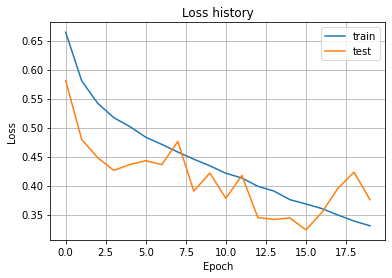

In [32]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

In [33]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [34]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [35]:
epochs = 20

model = gru_init
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_loss, running_items, running_right, batches = 0.0, 0.0, 0.0, 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        running_loss += loss.item()
        batches += 1
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_dl)}]. ' \
            f'Loss: {running_loss / batches:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    train_loss_history.append(running_loss / batches)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_running_loss, batches = 0.0, 0.0, 0.0, 0.0
    for j, data in enumerate(val_dl):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        test_running_loss += test_loss.item()
        batches += 1
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_running_loss / batches)
    print(f'Test loss: {test_running_loss / batches:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/20]. Step [149/149]. Loss: 0.660. Acc: 0.597. Test loss: 0.544. Test acc: 0.805
Epoch [2/20]. Step [149/149]. Loss: 0.566. Acc: 0.694. Test loss: 0.429. Test acc: 0.861
Epoch [3/20]. Step [149/149]. Loss: 0.525. Acc: 0.724. Test loss: 0.402. Test acc: 0.863
Epoch [4/20]. Step [149/149]. Loss: 0.500. Acc: 0.742. Test loss: 0.403. Test acc: 0.844
Epoch [5/20]. Step [149/149]. Loss: 0.480. Acc: 0.756. Test loss: 0.427. Test acc: 0.821
Epoch [6/20]. Step [149/149]. Loss: 0.465. Acc: 0.766. Test loss: 0.421. Test acc: 0.820
Epoch [7/20]. Step [149/149]. Loss: 0.447. Acc: 0.776. Test loss: 0.408. Test acc: 0.822
Epoch [8/20]. Step [149/149]. Loss: 0.436. Acc: 0.785. Test loss: 0.408. Test acc: 0.825
Epoch [9/20]. Step [149/149]. Loss: 0.422. Acc: 0.790. Test loss: 0.403. Test acc: 0.827
Epoch [10/20]. Step [149/149]. Loss: 0.410. Acc: 0.799. Test loss: 0.395. Test acc: 0.827
Epoch [11/20]. Step [149/149]. Loss: 0.396. Acc: 0.809. Test loss: 0.401. Test acc: 0.829
Epoch [12/20]. Step

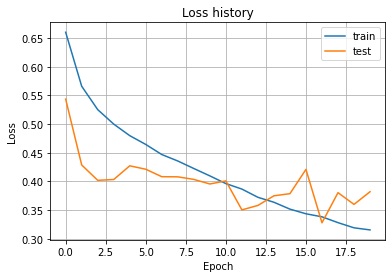

In [36]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();